In [12]:
import torch
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import glob
import os
import PIL

In [16]:
data_dir = "C://Users//aa310//桌面//datasets//faces"
batch_size = 32

class MyImageDataset(Dataset):
    def __init__(self, fnames):
        self.fnames = fnames
        self.num_samples = len(self.fnames)
        self.transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    def __getitem__(self, idx):
        fnames = self.fnames[idx]
        img = PIL.Image.open(fnames)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, "*"))
    return MyImageDataset(fnames)


dataset = get_dataset(data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_dim, out_channels=out_dim, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(),
            )

        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU(),
        )

        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(in_channels=dim, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh(),
        )

        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, LSGAN, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
        
        if LSGAN:
            self.ls = nn.Sequential(
                nn.Conv2d(in_dim, dim, 5, 2, 2), 
                nn.LeakyReLU(0.2),
                conv_bn_lrelu(dim, dim * 2),
                conv_bn_lrelu(dim * 2, dim * 4),
                conv_bn_lrelu(dim * 4, dim * 8),
                nn.Conv2d(dim * 8, 1, 4),
            )
        else:
            self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid(), 
            )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y
    


class LSGANDiscriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
            
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [18]:
LSGAN = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
z_dim = 100

G = Generator(in_dim=z_dim).to(device)
if LSGAN:
    D = Discriminator(True, 3).to(device)
else:
    D = Discriminator(False, 3).to(device)


G.train()
D.train()

criterion = nn.BCELoss()
def calc_loss(output, target):
    if LSGAN:
        return ((output - target) ** 2).sum()
    else:
        return criterion(output, target)

opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))

iters = 10
steps = 0

true_labels = torch.ones((batch_size)).to(device)
false_labels = torch.zeros((batch_size)).to(device)

D_loss_list = []
G_loss_list = []

for iter in tqdm(range(iters)):
    D_iter_loss = 0
    G_iter_loss = 0
    for data_batch in dataloader:
        images = data_batch.to(device)

        random_images = torch.randn(batch_size, z_dim).to(device)
        generated_images = G(random_images)

        # detach(): 创建一个相同的 tensor , 当执行反向传播时，这个 tensor 之后的参数不会进行更新
        # 这里只是要更新 discriminator ， 不需要 generator ，所以把他在 generator 之后截断梯度更新，保证反向传播时不会影响generator
        true_logits = D(images.detach())
        false_logits = D(generated_images.detach())

        right_loss = calc_loss(true_logits, true_labels)
        false_loss = calc_loss(false_logits, false_labels)

        loss_D = (right_loss + false_loss) / 2
        D_iter_loss += loss_D.data

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        if steps % 5 == 0:
            random_images = torch.randn(batch_size, z_dim).to(device)
            generated_images = G(random_images)

            # 这里更新 generator ，所以不需要 detach 截断梯度更新
            generated_logits = D(generated_images)

            loss_G = calc_loss(generated_logits, true_labels)
            G_iter_loss += loss_G.data

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        steps += 1
        
    D_loss_list.append(D_iter_loss)
    G_loss_list.append(G_iter_loss)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [18:47<00:00, 112.78s/it]


(32, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

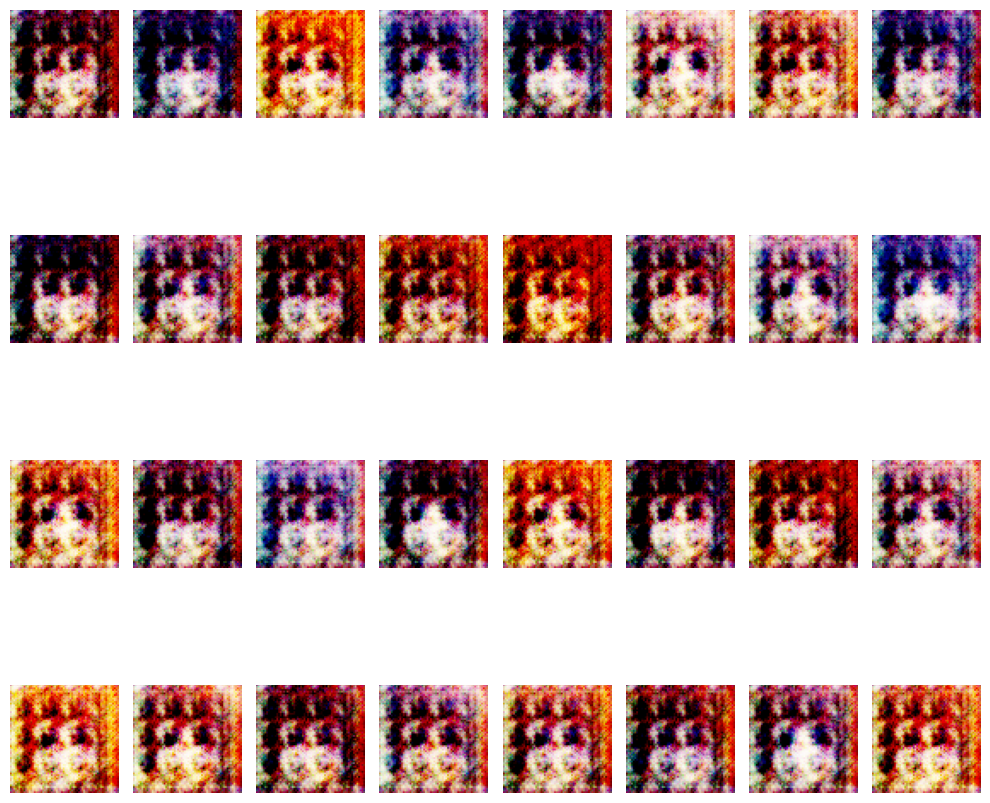

In [20]:
G.eval()
def generate_image():
    random_images = torch.randn(batch_size, z_dim).to(device)
    generated_images = G(random_images).permute(0, 2, 3, 1).cpu().detach().numpy()
    print(generated_images.shape)
    
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(32):
        ax = axes[i]
        ax.imshow(generated_images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
generate_image()